<a href="https://colab.research.google.com/github/fernanda0402/Doutorado/blob/main/Taxa_de_crescimento_GP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [100]:
# Bibliotecas:

import urllib.request
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import sympy as sp
import scipy.interpolate as interp
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm
from scipy.optimize import curve_fit
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

In [72]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

In [ ]:
!pip install -q condacolab
import condacolab
condacolab.install()
!mamba install pyccl

In [74]:
import pyccl as ccl

Vamos baixar os dados preditos de $f$.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [129]:
dados_f = np.loadtxt('/content/drive/MyDrive/Doutorado/reconstruction_data.txt')
dados_f

array([[0.        , 0.58125983, 0.66382431, 0.49869535],
       [0.003003  , 0.5823307 , 0.66450321, 0.50015819],
       [0.00600601, 0.58340146, 0.66518405, 0.50161888],
       ...,
       [2.99399399, 1.39723082, 1.74830403, 1.04615761],
       [2.996997  , 1.39763937, 1.74927963, 1.04599912],
       [3.        , 1.3980469 , 1.75025494, 1.04583887]])

Vamos nomear os dados e colunas:

In [130]:
# nomeando dados/colunas

zp = dados_f[:, 0] # o redshift é a primeira coluna
fp = dados_f[:, 1] # f(z) é a segunda coluna
fp_maissigma = dados_f[:, 2] # f + 2 sigma é a terceira coluna
fp_menossigma = dados_f[:, 3] # f - 2 sigma é a quarta coluna

#print(z)

fp_sigma = (fp_maissigma + fp_menossigma)/2

# recorte
mask_zp = zp <= 2.0  # não dá certo fazer o corte nos dados

Vamos definir a função taxa de crescimento de estruturas a partir do modelo $\Lambda$CDM e plotá-la com os dados preditos de $f$.

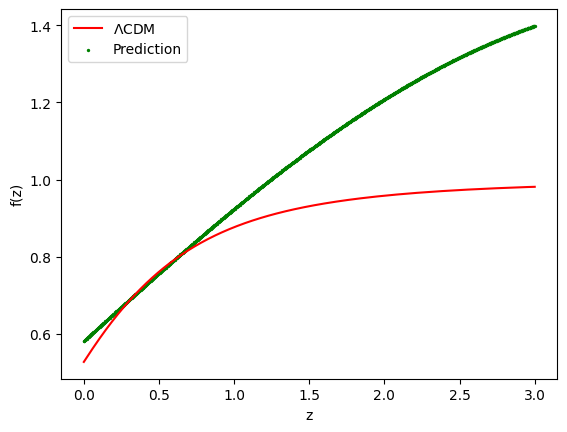

In [131]:
cosmo = ccl.Cosmology(
    Omega_c=0.2656, Omega_b=0.0494, w0 = -1, h=0.6727, sigma8=0.8120, n_s=0.9649) 


a = np.linspace(0.25, 1, 1000)  # fator de escala
delta = ccl.growth_factor(cosmo, a)  # contraste

# definindo o redshift em função do fator de escala
z = (1/a) - 1.

x = np.log(a)
y = np.log(delta)

f = np.gradient(y, x) # função taxa de crescimento


# plote
plt.plot(z, f, color='red', label='$\Lambda$CDM')
plt.scatter(zp, fp, color='green', label='Prediction', s=2)

# legenda, label e título
plt.xlabel('z')
plt.ylabel('f(z)')
plt.legend(loc='best')
plt.show()

Faremos um gráfico com os valores do modelo $\Lambda$CDM com as variações para $\Omega_{m0}$ e $\omega_0$ escolhidas: $\pm$ 0.05 e $\pm$ 0.2, respectivamente.

0.22182350265904513
-1.4758475179113546


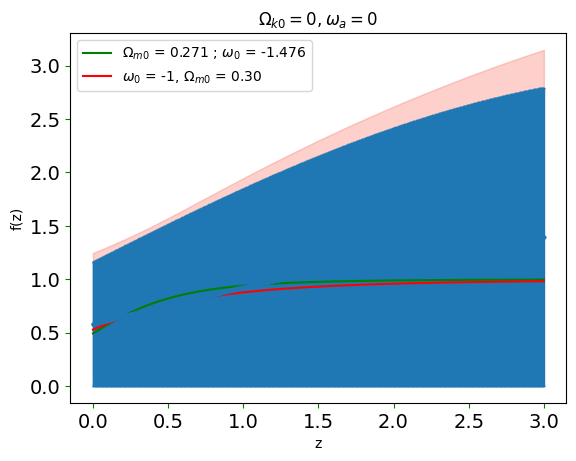

In [132]:
# definindo a função f para o caso de Om e w0 variando

def f1_teorico(z, Om_c, w0):

    cosmo = ccl.Cosmology(Omega_c=Om_c, h=0.6727, Omega_b=0.049411603, Omega_k=0, w0=w0, wa=0, sigma8=0.8120, n_s=0.9649)

    a = 1/(1+z)

    return ccl.background.growth_rate(cosmo, a)

# ajuste da função

popt, pcov = curve_fit(f1_teorico, zp, fp, sigma=fp_sigma, p0=[0.25,-1.2], bounds=([-1.5, -1.5], [1., 1.]), method='trf')
print(popt[0])
print(popt[1])

p1 = popt[0] + 0.049411603
p2 = popt[1]

# plote

#best-fit
zi = np.linspace(min(zp), max(zp), 1000)

fig, ax = plt.subplots()
plt.tick_params(labelsize=14, color='green')
plt.errorbar(zp, fp, yerr = fp_sigma, fmt='o', linestyle="--", markersize=2, elinewidth=1, capsize=1)
plt.plot(zi, f1_teorico(zi, popt[0], popt[1]), color='green', label=r'$\Omega_{m0}$ = '+str(np.round(p1, 3))+' ; '+'$\omega_0$ = '+str(np.round(p2, 3)))

#curvas e dados
ax.plot(z, f, label='$\omega_0$ = -1, $\Omega_{m0}$ = 0.30', color='red')

# área sombreada
ax.fill_between(zp, fp + fp_maissigma, fp - fp_menossigma, alpha=0.2, color='salmon')
ax.fill_between(zp, fp + fp_maissigma, fp -  fp_menossigma, alpha=0.2, color='salmon')

# legenda, título e eixos
plt.legend(loc='best')
plt.xlabel('z')
plt.ylabel('f(z)')
plt.title('$\Omega_{k0} = 0, \omega_a = 0$')
plt.show()

Vamos fazer o plot da primeira derivada dos dados preditos de $f$ do Felipe com a curva da primeira derivada teórica (ou seja, oriunda do modelo $\Lambda$CDM) de $f$.

In [ ]:
!pip install derivative
from derivative import dxdt

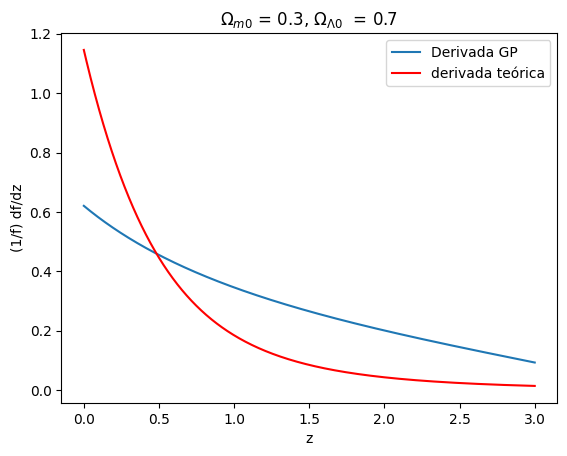

In [134]:
# DERIVADA DOS DADOS PREDITOS

# derivada usando spline

xgp = np.linspace(0,3.0,1000)
ygp = fp

# 4. Spline derivative with smoothing set to 0.01
result_gp = dxdt(ygp, xgp, kind="spline", s=1e-2)
derivada_gp = result_gp/fp



# DERIVADA TEÓRICA

cosmo = ccl.Cosmology(
    Omega_c=0.2656, Omega_b=0.0494, w0 = -1, h=0.6727, sigma8=0.8120, n_s=0.9649) 


a = np.linspace(0.25, 1, 1000)  # fator de escala
delta = ccl.growth_factor(cosmo, a)  # contraste

# definindo o redshift em função do fator de escala
z = (1/a) - 1.

gamma = 6/11
Om0 = 0.30
O_L0 = 1 - Om0

derivada_teo = ( (3 * gamma * O_L0)/( (1+z) * (Om0 * ((1+z)**3) + O_L0) ) )



# PLOTE
plt.plot(xgp, derivada_gp, label='Derivada GP')
plt.plot(z, derivada_teo, label='derivada teórica', color='red')

# legenda, título e eixos
plt.title('$\Omega_{m0}$ = 0.3, $\Omega_{\Lambda 0}$  = 0.7 ')
plt.ylabel('(1/f) df/dz')
plt.xlabel('z')
plt.legend()
plt.show()

Vamos reconstruir os dados, ou seja, obter dados preditos de $f$, usando o Gaussian Process do Felipe.

In [ ]:
# processo de reconstrução usando gaussian process

# dados reais de f
f_dados = np.array([0.56, 0.49, 0.49, 0.60, 0.70, 0.66, 0.70, 0.75, 0.73, 0.91, 0.90])
f_erro = np.array([0.07, 0.14, 0.12, 0.10, 0.18, 0.09, 0.07, 0.18, 0.07, 0.36, 0.24])
z_dados = np.array([0.013, 0.15, 0.18, 0.22, 0.35, 0.38, 0.41, 0.55, 0.60, 0.77, 1.40])


X = z_dados
X = np.atleast_2d(X).T
x_gp = np.atleast_2d(np.linspace(min(z_dados), max(z_dados), 1000)).T
y_gp = f_dados

kernel = C(1.) * RBF(length_scale=1)

gp = GaussianProcessRegressor(kernel=kernel, alpha=f_erro, n_restarts_optimizer=30)

gp.fit(X, y_gp)

f_p, f_psigma = gp.predict(x_gp, return_std=True)

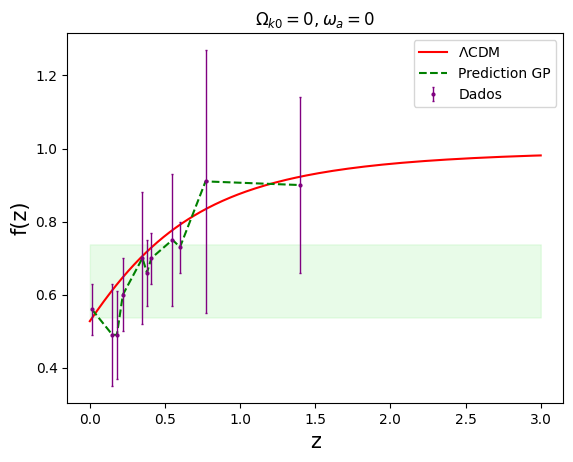

In [136]:
# MODELO LCDM
cosmo = ccl.Cosmology(
    Omega_c=0.2656, Omega_b=0.0494, w0 = -1, h=0.6727, sigma8=0.8120, n_s=0.9649) 


a = np.linspace(0.25, 1, 1000)  # fator de escala
delta = ccl.growth_factor(cosmo, a)  # contraste

# definindo o redshift em função do fator de escala
z = (1/a) - 1.

x = np.log(a)
y = np.log(delta)

f = np.gradient(y, x) # função taxa de crescimento


# PLOTE

fig, ax = plt.subplots()
plt.plot(z, f, color='red', label='$\Lambda$CDM')
plt.plot(X, y_gp, color='green', label='Prediction GP', linestyle="--")
#plt.scatter(zp, fp, color='green', s=2)
plt.errorbar(z_dados, f_dados, yerr = f_erro, color = 'purple', label='Dados', fmt='o', markersize=2, elinewidth=1, capsize=1)

# área sombreada
ax.fill_between(zp, f_p + f_psigma, f_p - f_psigma, alpha=0.2, color='lightgreen')

# legenda, label e título
plt.xlabel('z', fontsize=15)
plt.ylabel('f(z)', fontsize=15)
plt.legend(loc='best')
plt.title('$\Omega_{k0} = 0, \omega_a = 0$')
plt.show()

Vamos tentar usar outro processo gaussiano para a reconstrução da curva de $f(z)$. Este método se encontra no link: https://github.com/JCGoran/GaPP/tree/feature/python3

In [ ]:
!pip install git+https://github.com/JCGoran/GaPP@feature/python3#GaPP
from gapp import gp
from numpy import loadtxt, savetxt


Optimized hyperparameters:
theta = [0.6962485  2.43808246]


<ipython-input-138-137844b12659>:40: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r." (-> color='r'). The keyword argument will take precedence.
  plt.errorbar(x_gapp, y_gapp, e, fmt='r.', color='purple', markersize=10, label='Dados')


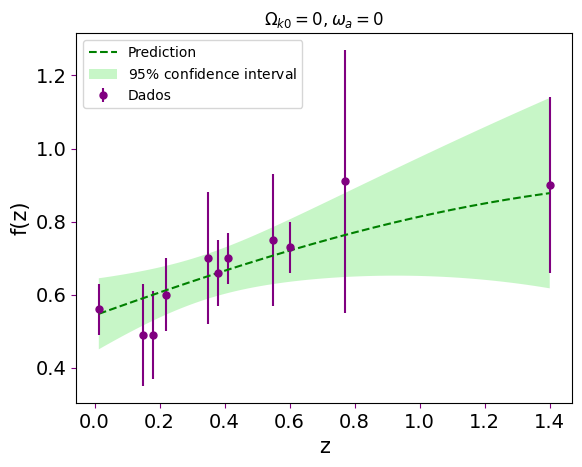

In [138]:
# baixando os dados
data = np.genfromtxt('/content/drive/MyDrive/Doutorado/fz_data.csv', delimiter=', ')

z_gapp = data[:, 0]

f_gapp = data[:, 1]

sig_f = data[:, 2]

# nomeando
x_gapp = z_gapp
y_gapp = f_gapp
e = sig_f

# xmin, xmax and nstar are interpreted as two-dimensional vectors
xmin = min(x_gapp)
xmax = max(x_gapp)
nstar = 1000

# initial values of the hyperparameters of the squared-exponential covariance function
initheta = [2.0, 2.0]

# initialization of the Gaussian Process
g = gp.GaussianProcess(x_gapp, y_gapp, e, cXstar=(xmin, xmax, nstar))

# training of the hyperparameters and reconstruction of the function
(rec, theta) = g.gp(theta=initheta)

xi = rec[:, 0]

y_pred = rec[:, 1]
sigma  = rec[:, 2]

y_pred_95_less = y_pred - 1.9600*sigma
y_pred_95_plus = y_pred + 1.9600*sigma

# Plot the function, the prediction and the 95% confidence interval 
plt.figure()
plt.tick_params(labelsize=14, color='purple')
plt.errorbar(x_gapp, y_gapp, e, fmt='r.', color='purple', markersize=10, label='Dados')
plt.plot(xi, y_pred, color = 'green', label='Prediction', linestyle="--")
plt.fill(np.concatenate([xi, xi[::-1]]),
         np.concatenate([y_pred - 1.9600 * sigma,
                        (y_pred + 1.9600 * sigma)[::-1]]),
         alpha=.5, color = 'lightgreen', ec='None', label=r'$95\%$ confidence interval')

# legenda, label e título
plt.xlabel('z', fontsize=15)
plt.ylabel('f(z)', fontsize=15)
plt.legend(loc='best')
plt.title('$\Omega_{k0} = 0, \omega_a = 0$')
plt.show()

H = xi, y_pred, sigma

Vamos fazer a primeira derivada do GaPP.

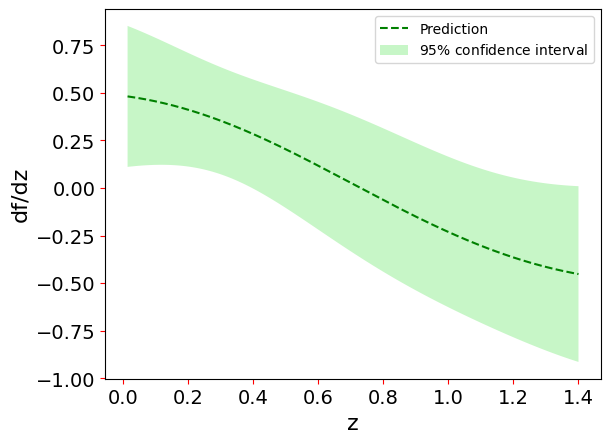

In [139]:
from gapp import dgp # dgp calcula a primeira, segunda e terceira derivada

# baixando os dados
data = np.genfromtxt('/content/drive/MyDrive/Doutorado/fz_data.csv', delimiter=', ')

z_gapp = data[:, 0]

f_gapp = data[:, 1]

sig_f = data[:, 2]

# nomeando
x_gapp = z_gapp
y_gapp = f_gapp
e = sig_f

xmin = min(x_gapp)
xmax = max(x_gapp)
nstar = 1000

# initial values of the hyperparameters
initheta = [2.0, 2.0]

# initialization of the Gaussian Process
g = dgp.DGaussianProcess(x_gapp, y_gapp, e, cXstar=(xmin, xmax, nstar))

# training of the hyperparameters and reconstruction of the function
(drec, theta) = g.dgp(thetatrain='False')

# the second and third derivatives use g.d2gp() and g.d3gp()

xi     = drec[:, 0]
y_pred = drec[:, 1]
sigma  = drec[:, 2]

y_pred_95_less = y_pred - 1.9600*sigma
y_pred_95_plus = y_pred + 1.9600*sigma


# Plot the function, the prediction and the 95% confidence interval 
plt.figure()
plt.tick_params(labelsize=14,color='red')
plt.plot(xi, y_pred, color='green', label='Prediction', linestyle="--")
plt.fill(np.concatenate([xi, xi[::-1]]),
         np.concatenate([y_pred - 1.9600 * sigma,
                        (y_pred + 1.9600 * sigma)[::-1]]),
         alpha=.5, fc='lightgreen', ec='None', label=r'$95\%$ confidence interval')

# legenda, label e título
plt.xlabel('z', fontsize=16)
plt.ylabel('df/dz', fontsize=16)
plt.legend(loc='best')
plt.show()

Porém, o que realmente queremos plotar é a razão $\frac{1}{f(z)} \frac{df}{dz}$.

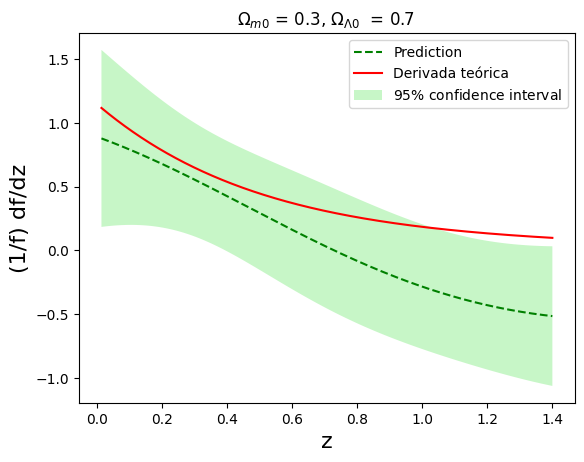

In [140]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

# baixando e nomeando dados
fz = np.genfromtxt('/content/drive/MyDrive/Doutorado/fz_recon.dat', delimiter='\t')

z_dgapp = fz[:, 0]
f_dgapp = fz[:, 1]

ef = fz[:, 2]

dfz = np.genfromtxt('/content/drive/MyDrive/Doutorado/dfz_recon.dat', delimiter='\t')

df = dfz[:, 1]

edf = dfz[:, 2]

df_f = df / f_dgapp

sigma = np.sqrt(((df_f) ** 2) * (((ef / f_dgapp) ** 2) + ((edf / df) ** 2)))



# DERIVADA DO MODELO LCDM

cosmo = ccl.Cosmology(
    Omega_c=0.2656, Omega_b=0.0494, h=0.6727, sigma8=0.8120, n_s=0.9649,
    matter_power_spectrum='linear')

zi = np.linspace(min(z_dgapp), max(z_dgapp), 1000)

ai = 1. / (1. + zi)

gamma = 6/11
Om0 = 0.30
O_L0 = 1 - Om0

derivada_teo = ( (3 * gamma * O_L0)/( (1+zi) * (Om0 * ((1+zi)**3) + O_L0) ) )



# PLOTE
plt.plot(z_dgapp, df_f, color='green', label='Prediction', linestyle="--")
plt.plot(zi, derivada_teo, label='Derivada teórica', color='red')
plt.fill(np.concatenate([z_dgapp, z_dgapp[::-1]]),
         np.concatenate([df_f - 1.9600 * sigma,
                        (df_f + 1.9600 * sigma)[::-1]]),
         alpha=.5, fc='lightgreen', ec='None', label='$95\%$ confidence interval')

# legenda, label e título
plt.title('$\Omega_{m0}$ = 0.3, $\Omega_{\Lambda 0}$  = 0.7 ')
plt.xlabel('z', fontsize=16)
plt.ylabel('(1/f) df/dz', fontsize=16)
plt.legend(loc='best')
plt.show()

Vamos observar como a curva da primeira derivada teórica se comporta conforme variamos $\gamma$.

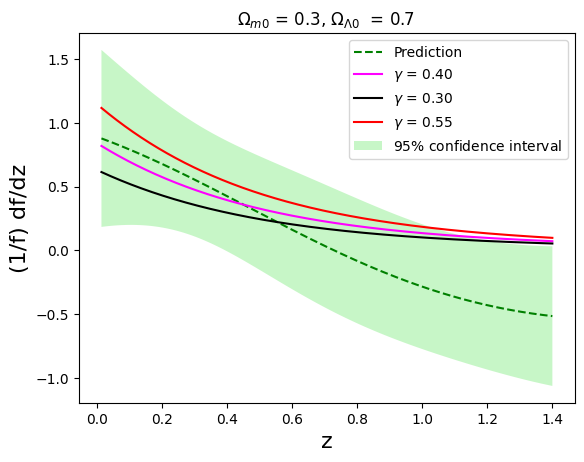

In [141]:
# derivada modelo LCDM com gamma = 0.40

cosmo1 = ccl.Cosmology(
    Omega_c=0.2656, Omega_b=0.0494, h=0.6727, sigma8=0.8120, n_s=0.9649,
    matter_power_spectrum='linear')

z1 = np.linspace(min(z_dgapp), max(z_dgapp), 1000)

a1 = 1. / (1. + z1)

gamma1 = 0.40
Om0 = 0.30
O_L0 = 1 - Om0

derivada_teo1 = ( (3 * gamma1 * O_L0)/( (1+z1) * (Om0 * ((1+z1)**3) + O_L0) ) )



# derivada modelo LCDM com gamma = 0.30

cosmo2 = ccl.Cosmology(
    Omega_c=0.2656, Omega_b=0.0494, h=0.6727, sigma8=0.8120, n_s=0.9649,
    matter_power_spectrum='linear')

z2 = np.linspace(min(z_dgapp), max(z_dgapp), 1000)

a2 = 1. / (1. + z2)

gamma2 = 0.30
Om0 = 0.30
O_L0 = 1 - Om0

derivada_teo2 = ( (3 * gamma2 * O_L0)/( (1+z2) * (Om0 * ((1+z2)**3) + O_L0) ) )



# PLOTE
plt.plot(z_dgapp, df_f, color='green', label='Prediction', linestyle="--")
plt.plot(z1, derivada_teo1, label='$\gamma$ = 0.40', color='magenta')
plt.plot(z2, derivada_teo2, label='$\gamma$ = 0.30', color='black')
plt.plot(zi, derivada_teo, label='$\gamma$ = 0.55', color='red')
plt.fill(np.concatenate([z_dgapp, z_dgapp[::-1]]),
         np.concatenate([df_f - 1.9600 * sigma,
                        (df_f + 1.9600 * sigma)[::-1]]),
         alpha=.5, fc='lightgreen', ec='None', label='$95\%$ confidence interval')

# legenda, label e título
plt.title('$\Omega_{m0}$ = 0.3, $\Omega_{\Lambda 0}$  = 0.7 ')
plt.xlabel('z', fontsize=16)
plt.ylabel('(1/f) df/dz', fontsize=16)
plt.legend(loc='best')
plt.show()

Vamos encontrar, com um best-fit, o melhor valor de $\gamma$ que faz com que a curva da derivada teórica se ajuste à curva da derivada do GaPP.

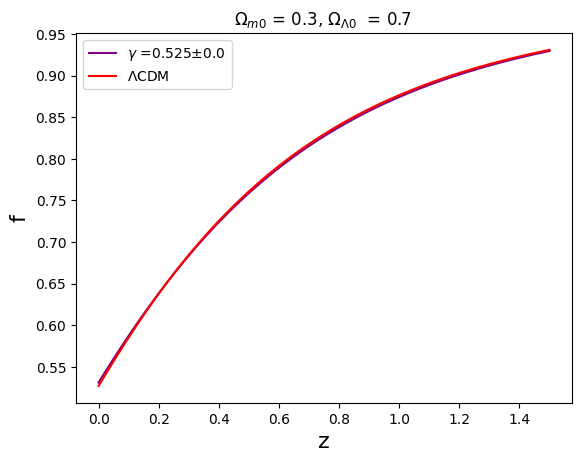

In [146]:
# BEST-FIT

cosmo_new = ccl.Cosmology(
    Omega_c=0.2656, Omega_b=0.0494, w0 = -1, h=0.6727, sigma8=0.8120, n_s=0.9649) 


a_new = np.linspace(0.4, 1, 1000)  # fator de escala
delta_new = ccl.growth_factor(cosmo_new, a_new)  # contraste

# definindo o redshift em função do fator de escala
z_new = (1/a_new) - 1.

x_new = np.log(a_new)
y_new = np.log(delta_new)

f_new = np.gradient(y_new, x_new) # função taxa de crescimento


# definindo O_m
Om0 = 0.30
Om = (Om0*((a_new)**(-3)))/(Om0*((a_new)**(-3)) + 1 - Om0)


def g(om, gamma):
  g = Om ** gamma
  return g


# ajuste da função

curve = curve_fit(g, z_new, f_new) # primeiro é a função e depois as variáveis
g0 = round(curve[0][0], 3) #valor do fit, ele vem no 00 da matriz, o 2 é o número de casas decimais
ge = round(curve[1][0][0], 3) #valor do erro doplt.plot(x,f(x,curve[0])



# MODELO LCDM
cosmo = ccl.Cosmology(
    Omega_c=0.2656, Omega_b=0.0494, w0 = -1, h=0.6727, sigma8=0.8120, n_s=0.9649) 


a = np.linspace(0.4, 1, 1000)  # fator de escala
delta = ccl.growth_factor(cosmo, a)  # contraste

# definindo o redshift em função do fator de escala
z = (1/a) - 1.

x = np.log(a)
y = np.log(delta)

f = np.gradient(y, x) # função taxa de crescimento



# plote
plt.plot(z_new,g(z_new,curve[0]), color='purple', label='$\gamma$ ='+str(g0)+'$\pm$'+str(ge))
plt.plot(z, f, color='red', label='$\Lambda$CDM')

# legenda, label e título
plt.title('$\Omega_{m0}$ = 0.3, $\Omega_{\Lambda 0}$  = 0.7 ')
plt.xlabel('z', fontsize=16)
plt.ylabel('f', fontsize=16)
plt.legend(loc='best')
plt.show()

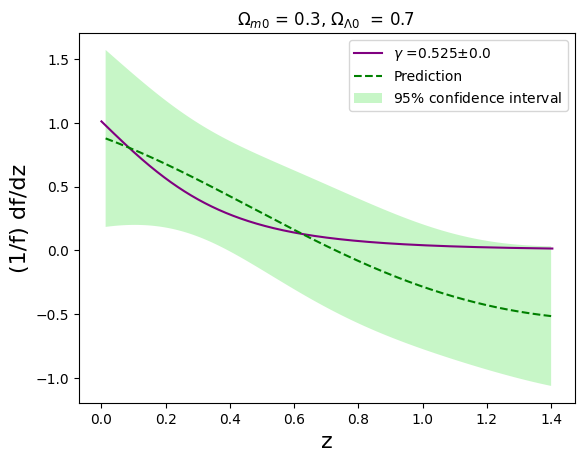

In [148]:
# DERIVADA TEÓRICA COM BEST-FIT DE GAMMA

cosmo4 = ccl.Cosmology(
    Omega_c=0.2656, Omega_b=0.0494, w0 = -1, h=0.6727, sigma8=0.8120, n_s=0.9649) 


a4 = np.linspace(0.416, 1, 1000)  # fator de escala
delta4 = ccl.growth_factor(cosmo4, a4)  # contraste

# definindo o redshift em função do fator de escala
z4 = (1/a4) - 1.

x4 = np.log(a4)
y4 = np.log(delta4)

f4 = np.gradient(y4, x4) # função taxa de crescimento




# BEST-FIT DE GAMMA

# definindo o valor de om
om = 0.30
oL = 1 - om

# definindo a função
def dteo(om, gamma1):
  dteo = ( (3 * gamma1 * oL)/( (1+z4) * (om * ((1+z4)**3) + oL) ) )
  return dteo

# ajuste da função

curve1 = curve_fit(dteo, z4, f4) # primeiro é a função e depois as variáveis
dteo0 = round(curve1[0][0], 3) #valor do fit, ele vem no 00 da matriz, o 2 é o número de casas decimais
dteoe = round(curve1[1][0][0], 3) #valor do erro doplt.plot(x,f(x,curve[0])



# DERIVADA GAPP

# baixando e nomeando dados
fz = np.genfromtxt('/content/drive/MyDrive/Doutorado/fz_recon.dat', delimiter='\t')

z_dgapp = fz[:, 0]
f_dgapp = fz[:, 1]

ef = fz[:, 2]

dfz = np.genfromtxt('/content/drive/MyDrive/Doutorado/dfz_recon.dat', delimiter='\t')

df = dfz[:, 1]

edf = dfz[:, 2]

df_f = df / f_dgapp

sigma = np.sqrt(((df_f) ** 2) * (((ef / f_dgapp) ** 2) + ((edf / df) ** 2)))


# PLOTE
plt.plot(z4,dteo(z4,curve1[0]), color='purple', label='$\gamma$ ='+str(g0)+'$\pm$'+str(ge))
plt.plot(z_dgapp, df_f, color='green', label='Prediction', linestyle="--")
plt.fill(np.concatenate([z_dgapp, z_dgapp[::-1]]),
         np.concatenate([df_f - 1.9600 * sigma,
                        (df_f + 1.9600 * sigma)[::-1]]),
         alpha=.5, fc='lightgreen', ec='None', label='$95\%$ confidence interval')

# legenda, label e título
plt.title('$\Omega_{m0}$ = 0.3, $\Omega_{\Lambda 0}$  = 0.7 ')
plt.xlabel('z', fontsize=16)
plt.ylabel('(1/f) df/dz', fontsize=16)
plt.legend(loc='best')
plt.show()